In [1]:
import pandas as pd

df = pd.read_csv('data/ObesityDataSet.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [2]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['NObeyesdad'] = label_encoder.fit_transform(df['NObeyesdad'])


In [4]:
label_encoder.inverse_transform([0, 1])

array(['Insufficient_Weight', 'Normal_Weight'], dtype=object)

In [5]:
from sklearn.model_selection import train_test_split

x = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'MLP Classifier': MLPClassifier()
}


In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, make_column_selector(dtype_exclude=object)),
        ('cat', categorical_transformer, make_column_selector(dtype_include=object)),
    ]
)

In [8]:
import json
import os.path


names = {}
for f in x.select_dtypes(include=['object']).columns:
    if 'cat' not in names:
        names['cat'] = {}
    names['cat'][f] = df[f].unique().tolist()
names['num'] = x.select_dtypes(include=['int64', 'float64']).columns.tolist()

if not os.path.isdir('files'):
    os.makedirs('files')

with open('files/column_data.json', 'w') as f:
    json.dump(names, f)


In [9]:
from sklearn.metrics import accuracy_score

pipeline_models = {}
accuracy_scores = {}

for name, model in models.items():
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', model),
        ]
    )
    pipeline.fit(x_train, y_train)
    pipeline_models[name] = pipeline

    # fill accuracy
    y_pred = pipeline.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = accuracy

/home/mo/miniconda3/envs/tf_env/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/mo/miniconda3/envs/tf_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [10]:
df_models = pd.DataFrame(accuracy_scores.items(), columns=['model', 'score'])
df_models.head()

,model,score
0,Logistic Regression,0.872340
1,K-Nearest Neighbors,0.820331
2,Decision Tree,0.945626
3,Random Forest,0.940898
4,SVC,0.931442


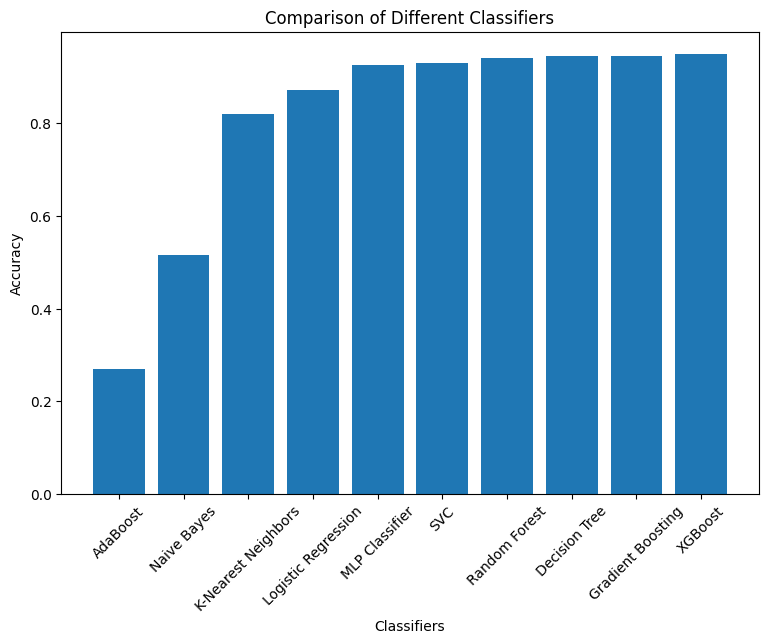

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))

plt.bar('model', 'score', data=df_models.sort_values('score'))
plt.ylabel('Accuracy')
plt.xlabel('Classifiers')
plt.title('Comparison of Different Classifiers')
plt.xticks(rotation=45)
plt.show()


In [12]:
import pickle

with open(f'files/pipeline_models.pkl', 'wb') as f:
    pickle.dump(pipeline_models, f)

with open('files/encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
